# Collecting and Processing Environmental and Contextual Data for NYC Restaurants

This section focuses on gathering, cleaning, and processing relevant environmental and contextual factors that may influence restaurant performance and customer experience. By integrating data on public transportation, proximity to romantic locations, noise pollution, socioeconomic conditions, and pricing, we constructed a comprehensive dataset. These processed variables will serve as key inputs for further evaluation and analysis.

In [12]:
import geopandas as gpd

review = gpd.read_file("restaurants_reviews_final.geojson")
info = gpd.read_file("restaurants_info.geojson")

In [13]:
info.head()

,title,price,categoryName,address,neighborhood,street,city,postalCode,state,location,totalScore,reviewsCount,url,latitude,longitude,geometry
0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,Staten Island,10305,New York,"{'lat': 40.6124623, 'lng': -74.071427}",4.7,320,https://www.google.com/maps/search/?api=1&quer...,40.612462,-74.071427,POINT (-74.07143 40.61246)
1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,Brooklyn,11209,New York,"{'lat': 40.6216254, 'lng': -74.0320368}",4.6,276,https://www.google.com/maps/search/?api=1&quer...,40.621625,-74.032037,POINT (-74.03204 40.62163)
2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,Brooklyn,11209,New York,"{'lat': 40.6313072, 'lng': -74.0281532}",4.4,331,https://www.google.com/maps/search/?api=1&quer...,40.631307,-74.028153,POINT (-74.02815 40.63131)
3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,New York,10028,New York,"{'lat': 40.7773172, 'lng': -73.9616247}",2.9,1061,https://www.google.com/maps/search/?api=1&quer...,40.777317,-73.961625,POINT (-73.96162 40.77732)
4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,New York,10021,New York,"{'lat': 40.7744222, 'lng': -73.9631514}",3.7,61,https://www.google.com/maps/search/?api=1&quer...,40.774422,-73.963151,POINT (-73.96315 40.77442)


In [ ]:
columns_to_keep = ['title', 'price', 'categoryName', 'address', 
                   'neighborhood', 'street', 'url', 'geometry']
info_cleaned = info[columns_to_keep]

info_cleaned = info_cleaned.to_crs(epsg=4326)
info_cleaned.head()

Parking availability can be a significant factor for customers driving to restaurants. We calculated the distance to the nearest parking lot for each restaurant, providing a realistic measure of parking convenience.

## 01 Proximity to Parking Lots

In [15]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
parking_lot = pd.read_csv("DOITT_PARKING_LOT.csv")

parking_lot_gdf = gpd.GeoDataFrame(parking_lot, 
                                  geometry=gpd.GeoSeries.from_wkt(parking_lot['the_geom']),
                                  crs="EPSG:4326")


parking_lot_gdf = parking_lot_gdf.to_crs(epsg=32618)


parking_lot_gdf['centroid'] = parking_lot_gdf.geometry.centroid


parking_lot_points = parking_lot_gdf.set_geometry('centroid')

parking_lot_points.head()

,the_geom,SOURCE_ID,FEAT_CODE,SUB_CODE,STATUS,SHAPE_Leng,SHAPE_Area,geometry,centroid
0,MULTIPOLYGON (((-73.97910559725612 40.69049642...,21500000001,5000,500000,Unchanged,778.318836,32676.073685,"MULTIPOLYGON (((586259.846 4504901.215, 586260...",POINT (586255.612 4504869.513)
1,MULTIPOLYGON (((-73.97943374194773 40.69316130...,21500000002,5000,500000,Updated,3737.772791,108080.622252,"MULTIPOLYGON (((586228.684 4505196.711, 586228...",POINT (586161.547 4505138.654)
2,MULTIPOLYGON (((-73.9832399249372 40.702812757...,21500000003,5000,500000,Unchanged,442.772495,5407.860486,"MULTIPOLYGON (((585894.692 4506264.356, 585893...",POINT (585879.620 4506256.939)
3,MULTIPOLYGON (((-73.98189157977659 40.70310347...,21500000004,5000,500000,Unchanged,284.623893,4027.729151,"MULTIPOLYGON (((586008.226 4506297.946, 586007...",POINT (585995.753 4506294.055)
4,MULTIPOLYGON (((-73.98594989444811 40.70232449...,21500000005,5000,500000,Unchanged,1567.687419,122903.007235,"MULTIPOLYGON (((585666.379 4506207.509, 585666...",POINT (585687.785 4506167.346)


In [16]:
info_cleaned = info_cleaned.to_crs(epsg=32618)

In [17]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


restaurant_coords = np.array(list(zip(info_cleaned.geometry.x, info_cleaned.geometry.y)))
parking_coords = np.array(list(zip(parking_lot_points.geometry.x, parking_lot_points.geometry.y)))


tree = cKDTree(parking_coords)


distances, indices = tree.query(restaurant_coords)


info_cleaned['nearest_parking_distance'] = distances

info_cleaned.head()

,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance
0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (578550.560 4496152.507),23.399102
1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (581871.546 4497205.555),131.466634
2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (582188.160 4498283.901),128.852259
3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (587622.919 4514556.245),550.739266
4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (587497.885 4514233.353),429.052337


## 02 Public Transportation Accessibility

To measure accessibility, we calculated the number of bus stops and subway stations within a 500-meter radius of each restaurant. A combined Public Transport Score was created to quantify the convenience of reaching these locations via public transit.

In [18]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


bus_shelters = pd.read_csv("Bus_Stop_Shelter_20241215.csv")
bus_shelters_gdf = gpd.GeoDataFrame(bus_shelters, 
                                   geometry=gpd.points_from_xy(bus_shelters['Longitude'], bus_shelters['Latitude']),
                                   crs="EPSG:4326")

subway_stations = pd.read_csv("MTA_Subway_Stations_20241216.csv")
subway_gdf = gpd.GeoDataFrame(subway_stations, 
                              geometry=gpd.points_from_xy(subway_stations['GTFS Longitude'], subway_stations['GTFS Latitude']),
                              crs="EPSG:4326")


info_cleaned = info_cleaned.to_crs(epsg=32618)
bus_shelters_gdf = bus_shelters_gdf.to_crs(epsg=32618)
subway_gdf = subway_gdf.to_crs(epsg=32618)


buffer_radius = 500  
info_cleaned['buffer'] = info_cleaned.geometry.buffer(buffer_radius)


def count_within_buffer(buffer, gdf):
 
    return gdf.within(buffer).sum()


info_cleaned['bus_count_500m'] = info_cleaned['buffer'].apply(
    lambda buf: count_within_buffer(buf, bus_shelters_gdf)
)


info_cleaned['subway_count_500m'] = info_cleaned['buffer'].apply(
    lambda buf: count_within_buffer(buf, subway_gdf)
)


info_cleaned['public_transport_score'] = info_cleaned['bus_count_500m'] * 1 + info_cleaned['subway_count_500m'] * 3


info_cleaned = info_cleaned.drop(columns='buffer')

info_cleaned.head()

,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance,bus_count_500m,subway_count_500m,public_transport_score
0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (578550.560 4496152.507),23.399102,1,0,1
1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (581871.546 4497205.555),131.466634,3,1,6
2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (582188.160 4498283.901),128.852259,5,1,8
3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (587622.919 4514556.245),550.739266,2,1,5
4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (587497.885 4514233.353),429.052337,6,1,9


## 03 Proximity to Romantic Locations

We selected parks, waterfronts, museums, and sculpture gardens as romantic destinations due to their association with nature, scenic beauty, and cultural value. The distance from each restaurant to the nearest boundary of these locations was calculated to evaluate romantic appeal.


/var/folders/7h/jtn8ncw16d59q490lkn0lqlh0000gn/T/ipykernel_94434/3253382405.py:12: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  parks = ox.geometries_from_place(city, tags={'leisure': 'park'})
/var/folders/7h/jtn8ncw16d59q490lkn0lqlh0000gn/T/ipykernel_94434/3253382405.py:13: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  waterfronts = ox.geometries_from_place(city, tags={'natural': 'water', 'lei

                      title  nearest_romantic_distance
0            Phil-Am Kusina                 284.550961
1              H & L Bagels                 404.126647
2        Coszcal De Allende                 290.370106
3                    E.A.T.                 145.836623
4  Dowling's at The Carlyle                 126.697833


/var/folders/7h/jtn8ncw16d59q490lkn0lqlh0000gn/T/ipykernel_94434/3253382405.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


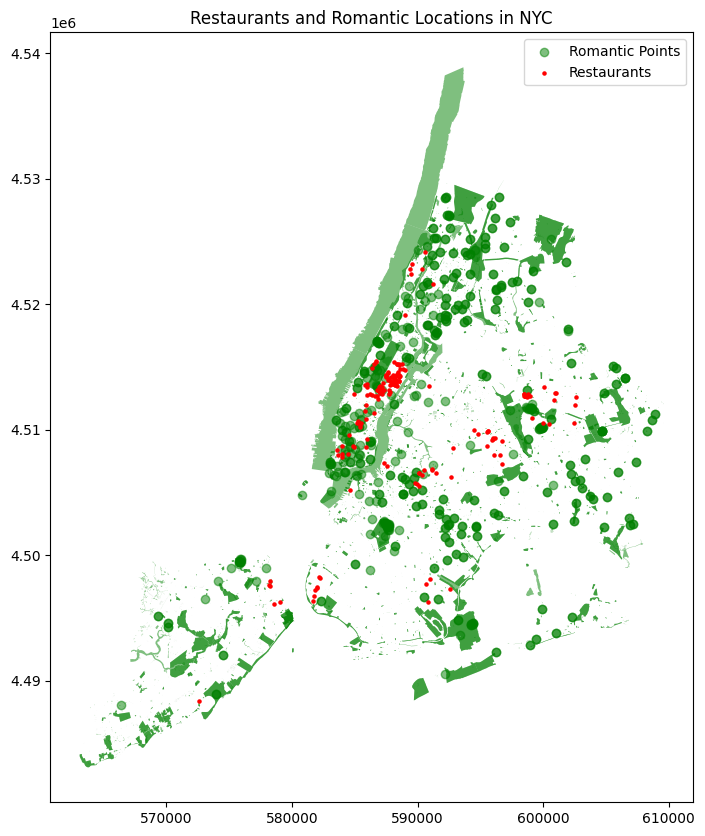

In [19]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
import matplotlib.pyplot as plt


city = "New York City, New York, USA"


parks = ox.geometries_from_place(city, tags={'leisure': 'park'})
waterfronts = ox.geometries_from_place(city, tags={'natural': 'water', 'leisure': 'park'})
culture_areas = ox.geometries_from_place(city, tags={'tourism': 'museum'})
sculpture_gardens = ox.geometries_from_place(city, tags={'leisure': 'garden'})


points_of_interest = pd.concat([parks, waterfronts, culture_areas, sculpture_gardens])
points_of_interest = points_of_interest[points_of_interest.geometry.notnull()]
points_of_interest = points_of_interest.to_crs(epsg=32618)

info_cleaned = info_cleaned.to_crs(epsg=32618)


def nearest_distance(row, poi_gdf):

    nearest_geom = poi_gdf.geometry.apply(lambda geom: row.geometry.distance(geom))
    return nearest_geom.min()


info_cleaned['nearest_romantic_distance'] = info_cleaned.apply(
    lambda row: nearest_distance(row, points_of_interest), axis=1
)


print(info_cleaned[['title', 'nearest_romantic_distance']].head())


fig, ax = plt.subplots(figsize=(10, 10))
points_of_interest.plot(ax=ax, color='green', alpha=0.5, label='Romantic Points')
info_cleaned.plot(ax=ax, color='red', markersize=5, label='Restaurants')
plt.title("Restaurants and Romantic Locations in NYC")
plt.legend()
plt.show()

In [20]:
info_cleaned.head()

,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance,bus_count_500m,subway_count_500m,public_transport_score,nearest_romantic_distance
0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (578550.560 4496152.507),23.399102,1,0,1,284.550961
1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (581871.546 4497205.555),131.466634,3,1,6,404.126647
2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (582188.160 4498283.901),128.852259,5,1,8,290.370106
3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (587622.919 4514556.245),550.739266,2,1,5,145.836623
4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (587497.885 4514233.353),429.052337,6,1,9,126.697833


## 04 Noise Pollution Analysis


Using noise complaint data, we spatially assigned the number of complaints to nearby streets. Each restaurant was linked to the closest street segment, and a Noise Count was added to represent the level of potential disturbance around the restaurant.


In [21]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import matplotlib.pyplot as plt

noise_file = '311_Noise_Complaints.csv'
df = pd.read_csv(noise_file)

df = df.dropna(subset=['Latitude', 'Longitude'])

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
noise_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

noise_gdf.head()

/var/folders/7h/jtn8ncw16d59q490lkn0lqlh0000gn/T/ipykernel_94434/1095868831.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(noise_file)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,geometry
0,56416252,01/01/2023 12:00:42 AM,01/01/2023 05:34:15 PM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10453.0,1871 SEDGWICK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.853848,-73.917709,"(40.85384789145288, -73.91770920479841)",POINT (-73.91771 40.85385)
1,56418136,01/01/2023 12:00:46 AM,01/01/2023 01:01:43 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11234.0,1621 EAST 51 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.620665,-73.926040,"(40.62066491675458, -73.92604033064251)",POINT (-73.92604 40.62066)
2,56418977,01/01/2023 12:01:38 AM,01/01/2023 03:24:32 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11429.0,206-20 104 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.710379,-73.752158,"(40.71037925060261, -73.75215815961971)",POINT (-73.75216 40.71038)
3,56413435,01/01/2023 12:01:54 AM,01/01/2023 12:43:40 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11218.0,15 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.639686,-73.979909,"(40.63968638126339, -73.97990859982983)",POINT (-73.97991 40.63969)
4,56412730,01/01/2023 12:01:57 AM,01/01/2023 12:49:42 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11378.0,70-10 GRAND AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.727633,-73.892487,"(40.72763257870112, -73.89248674712505)",POINT (-73.89249 40.72763)


In [22]:
import osmnx as ox


place_name = "New York City, New York, USA"
streets = ox.graph_from_place(place_name, network_type='drive')


street_gdf = ox.graph_to_gdfs(streets, nodes=False)  


street_gdf = street_gdf.to_crs(epsg=32618)  
street_gdf.head()

osmid  oneway lanes  ref  \
u        v         key                                                       
39076461 274283981 0                           25161349    True     2   CI   
         42854803  0                           25161578    True   NaN  NaN   
39076490 277672046 0                            5699971    True   NaN  NaN   
         277672005 0                         1014007069    True     3   CI   
39076504 462124701 0    [618709517, 618709515, 5700693]    True     1  NaN   

                                        name        highway maxspeed reversed  \
u        v         key                                                          
39076461 274283981 0    Cross Island Parkway       motorway   50 mph    False   
         42854803  0                     NaN  motorway_link      NaN    False   
39076490 277672046 0                     NaN  motorway_link      NaN    False   
         277672005 0    Cross Island Parkway       motorway   50 mph    False   
39076504 462124701 0                     NaN  motorway_link      NaN    False   

                         length  \
u        v         key            
39076461 274283981 0    819.503   
         42854803  0    268.145   
39076490 277672046 0    259.674   
         277672005 0    291.839   
39076504 462124701 0    433.148   

                                                                 geometry  \
u        v         key                                                      
39076461 274283981 0    LINESTRING (601691.230 4515738.523, 601702.418...   
         42854803  0    LINESTRING (601691.230 4515738.523, 601811.421...   
39076490 277672046 0    LINESTRING (604906.239 4513128.015, 604895.878...   
         277672005 0    LINESTRING (604906.239 4513128.015, 604878.921...   
39076504 462124701 0    LINESTRING (606011.533 4512148.657, 605979.445...   

                       bridge access tunnel width junction est_width  
u        v         key                                                
39076461 274283981 0      NaN    NaN    NaN   NaN      NaN       NaN  
         42854803  0      NaN    NaN    NaN   NaN      NaN       NaN  
39076490 277672046 0      NaN    NaN    NaN   NaN      NaN       NaN  
         277672005 0      NaN    NaN    NaN   NaN      NaN       NaN  
39076504 462124701 0      yes    NaN    NaN   NaN      NaN       NaN

In [23]:
street_gdf = street_gdf.drop(columns=['u', 'v', 'key'], errors='ignore')
noise_gdf = noise_gdf.to_crs(epsg=32618)
joined = gpd.sjoin_nearest(noise_gdf, street_gdf, how='left', distance_col='distance')

In [24]:
joined.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,maxspeed,reversed,length,bridge,access,tunnel,width,junction,est_width,distance
0,56416252,01/01/2023 12:00:42 AM,01/01/2023 05:34:15 PM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10453.0,1871 SEDGWICK AVENUE,...,NaN,False,171.798,NaN,NaN,NaN,NaN,NaN,NaN,1.253069
1,56418136,01/01/2023 12:00:46 AM,01/01/2023 01:01:43 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11234.0,1621 EAST 51 STREET,...,NaN,False,267.759,NaN,NaN,NaN,NaN,NaN,NaN,0.872901
2,56418977,01/01/2023 12:01:38 AM,01/01/2023 03:24:32 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11429.0,206-20 104 AVENUE,...,NaN,False,75.139,NaN,NaN,NaN,NaN,NaN,NaN,1.916960
3,56413435,01/01/2023 12:01:54 AM,01/01/2023 12:43:40 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11218.0,15 AVENUE,...,NaN,False,59.402,NaN,NaN,NaN,NaN,NaN,NaN,0.122752
4,56412730,01/01/2023 12:01:57 AM,01/01/2023 12:49:42 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11378.0,70-10 GRAND AVENUE,...,25 mph,False,104.863,NaN,NaN,NaN,NaN,NaN,NaN,2.388616


In [25]:
noise_gdf = noise_gdf.to_crs(epsg=32618)
street_gdf = street_gdf.to_crs(epsg=32618)


joined = gpd.sjoin_nearest(
    noise_gdf, street_gdf, how='left', distance_col='distance', max_distance=100
)

street_gdf['osmid'] = street_gdf['osmid'].apply(lambda x: x[0] if isinstance(x, list) else x)


joined['osmid'] = joined['osmid'].apply(lambda x: x[0] if isinstance(x, list) else x)


street_noise_count = joined.groupby('osmid').size()


street_gdf['noise_count'] = street_gdf['osmid'].map(street_noise_count).fillna(0)

street_gdf[['osmid', 'noise_count']].head(20)

osmid  noise_count
u        v          key                         
39076461 274283981  0      25161349          0.0
         42854803   0      25161578          0.0
39076490 277672046  0       5699971          0.0
         277672005  0    1014007069          0.0
39076504 462124701  0     618709517          0.0
         462122450  0     995490141          0.0
42421728 42435337   0     195743153         36.0
         42421731   0     420625565        125.0
         42432736   0    1271523197        102.0
42421731 42437916   0       5671485        608.0
         42432737   0     195743186        109.0
         42421728   0     420625565        125.0
         42421737   0     195743201        168.0
42421737 42421731   0     195743201        168.0
         42437917   0     420625563        169.0
         42421741   0     420625567         73.0
42421741 42432756   0     957050578        144.0
         1061531654 0     420625569         62.0
         42421737   0     420625567         73.0
42421745 1061531654 0     195743200         10.0

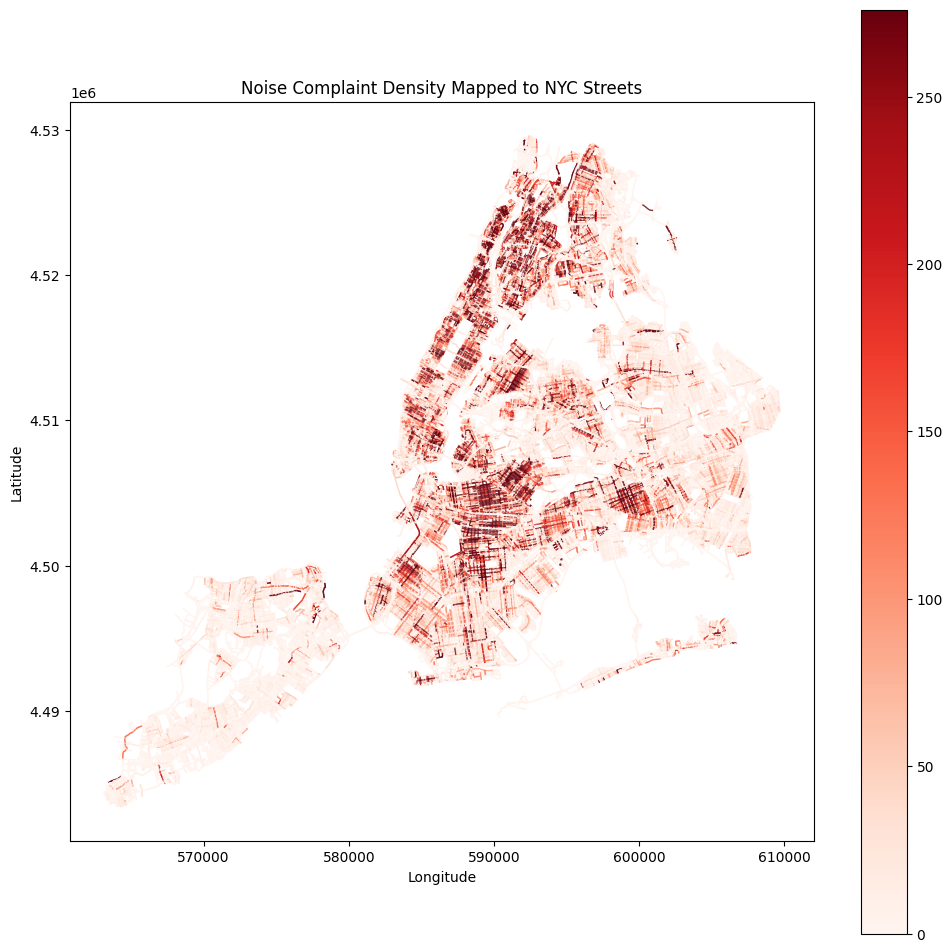

In [26]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(12, 12))
street_gdf.plot(
    ax=ax,
    column='noise_count',  
    cmap='Reds',  
    linewidth=1,  
    legend=True, 
    alpha=0.8,  
    vmin=0, vmax=street_gdf['noise_count'].quantile(0.95)  
)
plt.title("Noise Complaint Density Mapped to NYC Streets")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [27]:

info_cleaned = info_cleaned.to_crs(epsg=32618)
street_gdf = street_gdf.to_crs(epsg=32618)


info_cleaned = info_cleaned.reset_index(drop=False)  
info_cleaned.rename(columns={'index': 'restaurant_id'}, inplace=True)


restaurant_with_street = gpd.sjoin_nearest(
    info_cleaned, 
    street_gdf[['osmid', 'noise_count', 'geometry']], 
    how='left', 
    distance_col='distance_to_street'
)


restaurant_with_street = restaurant_with_street.sort_values(by='distance_to_street')
restaurant_with_street = restaurant_with_street.drop_duplicates(subset='restaurant_id')


info_cleaned['noise_count'] = restaurant_with_street.set_index('restaurant_id')['noise_count'].fillna(0)
info_cleaned.head()

,restaurant_id,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance,bus_count_500m,subway_count_500m,public_transport_score,nearest_romantic_distance,noise_count
0,0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (578550.560 4496152.507),23.399102,1,0,1,284.550961,7.0
1,1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (581871.546 4497205.555),131.466634,3,1,6,404.126647,508.0
2,2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (582188.160 4498283.901),128.852259,5,1,8,290.370106,457.0
3,3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (587622.919 4514556.245),550.739266,2,1,5,145.836623,39.0
4,4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (587497.885 4514233.353),429.052337,6,1,9,126.697833,270.0


## 05 Socioeconomic Context



Census tract-level data on median household income was used to represent the socioeconomic environment of each restaurant's location. This data was spatially joined to ensure each restaurant is associated with the income level of its corresponding tract.


In [29]:
import geopandas as gpd

# 1. 读取 Tract GeoJSON 数据
tracts_gdf = gpd.read_file("income.geojson") 


In [30]:
info_cleaned = info_cleaned.to_crs(tracts_gdf.crs)

# 3. 使用 sjoin 进行空间连接，将餐厅匹配到对应的 Tract
info_with_income = gpd.sjoin(
    info_cleaned, 
    tracts_gdf[['geometry', 'Median_Household_Income']],  # 选择几何列和收入列
    how='left', 
    predicate='within'  # 餐厅点必须在 Tract 内
)

# 4. 重置索引，确保没有重复值
info_with_income = info_with_income.reset_index(drop=True)

# 5. 合并收入数据回 info_cleaned
info_cleaned = info_cleaned.reset_index(drop=True)
info_cleaned['Median_Household_Income'] = info_with_income['Median_Household_Income'].fillna(0)

In [31]:
info_cleaned.head()

,restaurant_id,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance,bus_count_500m,subway_count_500m,public_transport_score,nearest_romantic_distance,noise_count,Median_Household_Income
0,0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (964418.659 162421.004),23.399102,1,0,1,284.550961,7.0,85183.0
1,1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (975356.367 165752.902),131.466634,3,1,6,404.126647,508.0,86582.0
2,2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (976435.614 169279.869),128.852259,5,1,8,290.370106,457.0,88155.0
3,3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (994878.394 222476.771),550.739266,2,1,5,145.836623,39.0,202632.0
4,4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (994456.004 221421.843),429.052337,6,1,9,126.697833,270.0,69583.0


## 06 Price Data Cleaning and Standardization


The price column, which includes inconsistent formats such as ranges (e.g., `$10–20`), fixed values with a plus sign (e.g., `$100+`), and symbolic representations (e.g., `$`, `$$`, `$$$`), was cleaned and standardized as follows:

For price ranges (e.g., `$10–20`), the average value of the range was computed.
For prices with a + sign (e.g., `$100+`), the minimum value was extracted (e.g., 100).
Symbolic prices were mapped to fixed numerical ranks to reflect affordability:
`$` → 10 (most affordable)
`$$` → 20
`$$$` → 50
`$$$$` → 100 (most expensive)
Missing values were imputed using the median price of the cleaned column.
This standardization ensures numerical consistency, making the price data suitable for comparison and further analysis.


In [32]:
import numpy as np
import re

# Function to clean and convert the 'price' column
def clean_price(price):
    if pd.isnull(price):  # Handle missing values
        return np.nan
    
    # Case 1: Price ranges (e.g., "$10–20")
    if re.match(r'\$\d+–\d+', price):
        numbers = list(map(int, re.findall(r'\d+', price)))  # Extract numbers
        return np.mean(numbers)  # Average of range
    
    # Case 2: "$100+" -> Treat as a single value
    elif re.match(r'\$\d+\+', price):
        return int(re.findall(r'\d+', price)[0])  # Take the value without '+'
    
    # Case 3: Symbolic values ("$", "$$", "$$$", "$$$$")
    elif price == '$':
        return 10  # Rank 1 (most affordable)
    elif price == '$$':
        return 20  # Rank 2
    elif price == '$$$':
        return 50  # Rank 3
    elif price == '$$$$':
        return 100  # Rank 4 (most expensive)
    
    # Default case: Treat unexpected values as NaN
    return np.nan

# Apply the function to the 'price' column in info_cleaned
info_cleaned['price_cleaned'] = info_cleaned['price'].apply(clean_price)

# Fill missing values in price_cleaned with the median
info_cleaned['price_cleaned'] = info_cleaned['price_cleaned'].fillna(info_cleaned['price_cleaned'].median())


print("Cleaned 'price' column in info_cleaned:")
print(info_cleaned[['price', 'price_cleaned']].head(10))

Cleaned 'price' column in info_cleaned:
     price  price_cleaned
0   $10–20           15.0
1    $1–10            5.5
2   $30–50           40.0
3   $30–50           40.0
4    $100+          100.0
5   $20–30           25.0
6   $10–20           15.0
7    $100+          100.0
8  $50–100           75.0
9   $30–50           40.0


In [33]:
info_cleaned.head()

,restaurant_id,title,price,categoryName,address,neighborhood,street,url,geometry,nearest_parking_distance,bus_count_500m,subway_count_500m,public_transport_score,nearest_romantic_distance,noise_count,Median_Household_Income,price_cleaned
0,0,Phil-Am Kusina,$10–20,Filipino restaurant,"556 Tompkins Ave., Staten Island, NY 10305",Rosebank,556 Tompkins Ave.,https://www.google.com/maps/search/?api=1&quer...,POINT (964418.659 162421.004),23.399102,1,0,1,284.550961,7.0,85183.0,15.0
1,1,H & L Bagels,$1–10,Bagel shop,"8818 3rd Ave, Brooklyn, NY 11209",Fort Hamilton,8818 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (975356.367 165752.902),131.466634,3,1,6,404.126647,508.0,86582.0,5.5
2,2,Coszcal De Allende,$30–50,Mexican restaurant,"7506 3rd Ave, Brooklyn, NY 11209",Bay Ridge,7506 3rd Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (976435.614 169279.869),128.852259,5,1,8,290.370106,457.0,88155.0,40.0
3,3,E.A.T.,$30–50,American restaurant,"1064 Madison Ave, New York, NY 10028",Manhattan,1064 Madison Ave,https://www.google.com/maps/search/?api=1&quer...,POINT (994878.394 222476.771),550.739266,2,1,5,145.836623,39.0,202632.0,40.0
4,4,Dowling's at The Carlyle,$100+,Restaurant,"35 E 76th St, New York, NY 10021",Manhattan,35 E 76th St,https://www.google.com/maps/search/?api=1&quer...,POINT (994456.004 221421.843),429.052337,6,1,9,126.697833,270.0,69583.0,100.0


In [34]:
output_path = "restaurant_info_with_envifactors.geojson"
info_cleaned.to_file(output_path, driver="GeoJSON")